In [5]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation

In [6]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [7]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [8]:
z_test_tsne_track = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/model_graphs/latent_space/3D_PCA_Latent_Space__31.npy")

Test_Images = np.load("/fast/gmooers/Preprocessed_Data/W_Variable/Trackable_Space_Time_W_Test.npy")
Max_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Max_Scalar.npy")
Min_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Min_Scalar.npy")

Test_Images = np.interp(Test_Images, (0, 1), (Min_Scalar, Max_Scalar))

# Horizonal Spatial Scale

In [9]:
def spectrum_gen(h, dx):
    nx = len(h)

    # Get half the length of the series to avoid redudant information
    npositive = nx//2
    pslice = slice(1, npositive)

    # Get frequencies
    freqs = np.fft.fftfreq(nx, d=dx)[pslice] 

    # Perform the fft 
    ft = np.fft.fft(h)[pslice]

    # Remove imaginary componant of the fft and square
    psraw = np.conjugate(ft) *ft

    # Double to account for the negative half that was removed above
    psraw *= 2.0

    # Normalization for the power spectrum
    psraw /= nx**2

    # Go from the Power Spectrum to Power Density
    psdraw = psraw * dx * nx

    return freqs, psraw, psdraw

In [10]:
ww_test = np.empty(Test_Images.shape)
for i in range(len(Test_Images)):
    ww_test[i,:,:] = (Test_Images[i,:,:] - np.nanmean(np.squeeze(Test_Images[i,:,:]),axis=1)[:,None])**2

In [11]:
def max_level_getter(w_array):
    level = np.empty(shape=(len(w_array)))
    magnitudes = np.empty(shape=(30))
    for i in range(len(w_array)):
        w_temp = np.squeeze(w_array[i,:,:])
        for j in range(len(w_temp)):
            magnitudes[j] = np.nansum(np.squeeze(w_temp[j,:]))
        level[i] = np.argmax(magnitudes) 
    
    return level
        
def spatial_fft(w_array):
    level = max_level_getter(w_array)
    spatial_labels = np.empty(shape=(len(w_array)))
    for i in range(len(w_array)):
        W_freqs, W_psraw, W_psdraw = spectrum_gen(w_array[i,int(level[i]),:], 1)
        w_max = np.argmax(W_psdraw)
        spatial_labels[i] = int(1/W_freqs[w_max])
    
    return spatial_labels

w_spatial_labels = spatial_fft(ww_test)

0
30
60
90
120
150
180
210
240
270
300
330
-0.10232586065850392
-0.25407117004160495
0.3306979011939728


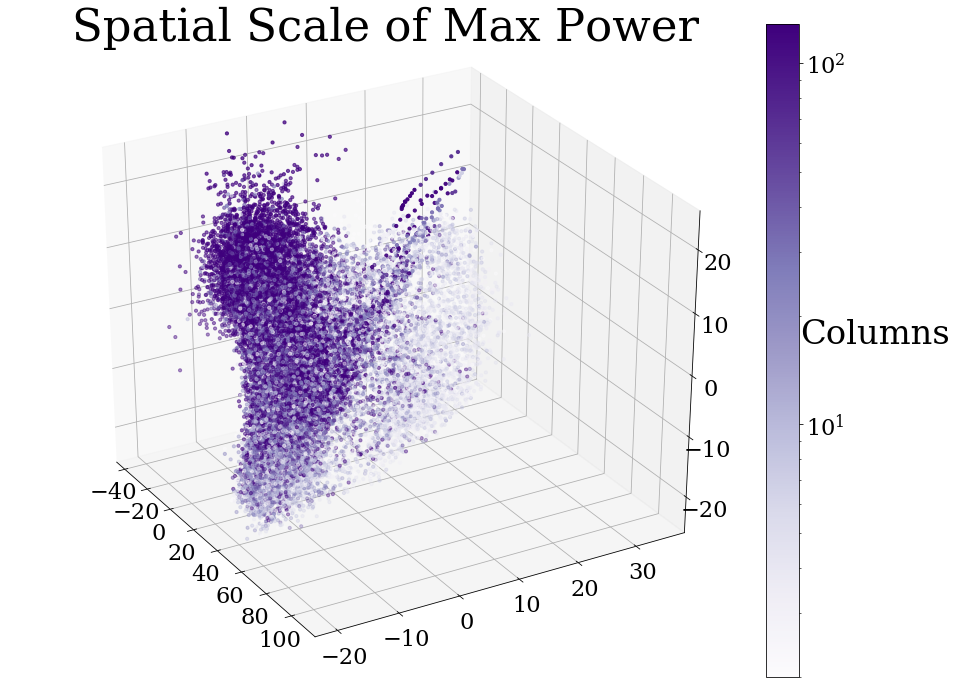

In [20]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=w_spatial_labels, cmap="Purples", s=10.0, norm=matplotlib.colors.LogNorm())
ax.set_title("Spatial Scale of Max Power", fontsize = fz*2.0, y = 1.05)

ax.set_zlim(-25,25)
cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Columns", rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.55)

for ii in range(360):
    ax.view_init(elev=30, azim=ii)
    if ii < 10:
        plt.savefig("Png_Storage/Conv_Agg_31/00"+str(ii)+".png")
    if ii >= 10 and ii < 100:
        plt.savefig("Png_Storage/Conv_Agg_31/0"+str(ii)+".png")
    if ii >= 100:
        plt.savefig("Png_Storage/Conv_Agg_31/"+str(ii)+".png")

In [ ]:
W_500_Label_All = np.nanmean(np.abs(np.squeeze(Test_Images[:,-12,:])), axis=1)

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=W_500_Label_All, cmap="Purples", s=10.0)
ax.set_title("Total Absolute Intensity at 500 hPa", fontsize = fz*2.0, y = 1.05)

ax.set_zlim(-25,25)
cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="m/s", rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.55)

for ii in range(360):
    ax.view_init(elev=30, azim=ii)
    if ii < 10:
        plt.savefig("Png_Storage/Intensity_31/00"+str(ii)+".png")
    if ii >= 10 and ii < 100:
        plt.savefig("Png_Storage/Intensity_31/0"+str(ii)+".png")
    if ii >= 100:
        plt.savefig("Png_Storage/Intensity_31/"+str(ii)+".png")

In [ ]:
path = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h0.2008-11.nc'
next_ds = xr.open_dataset(path)
land_frac = next_ds.LANDFRAC
land_frac = xr.DataArray.squeeze(land_frac).values
trop_land = land_frac[37:59, :]
geo_labels = np.zeros(shape=(int(len(z_test_tsne_track)/(22*144)), 22, 144))
geo_labels[:,:,:] = np.nan
for i in range(len(geo_labels)):
    geo_labels[i,:,:] = trop_land[:,:]  
geo_label_final = np.reshape(geo_labels, (geo_labels.size))

In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=geo_label_final, cmap="winter", s=10.0)
ax.set_title("Land Fraction", fontsize = fz*2.0, y = 1.05)

ax.set_zlim(-25,25)
cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Fraction", rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.55)

for ii in range(360):
    ax.view_init(elev=30, azim=ii)
    if ii < 10:
        plt.savefig("Png_Storage/Land_Sea_31/00"+str(ii)+".png")
    if ii >= 10 and ii < 100:
        plt.savefig("Png_Storage/Land_Sea_31/0"+str(ii)+".png")
    if ii >= 100:
        plt.savefig("Png_Storage/Land_Sea_31/"+str(ii)+".png")

In [25]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)

In [28]:
reshaped_Test_Images = np.empty(shape=(16,30,128,22,144))
lst_times = np.empty(shape=(16,22,144))

count = 0
for i in range(len(reshaped_Test_Images)):
    for j in range(len(reshaped_Test_Images[0][0][0])):
        for k in range(len(reshaped_Test_Images[0][0][0][0])):
            reshaped_Test_Images[i,:,:,j,k] = Test_Images[count,:,:]
            count = count+1
            
for i in range(16):
    for j in range(144):
        splitter = ((longitudes[j]/360.)*96.)/4.0 +i*0.15 +12.0
        if splitter >= 24.0:
            splitter = splitter - 24.0
            
        lst_times[i,:,j] = splitter

In [29]:
LTS_Label_final = np.reshape(lst_times, (lst_times.size))

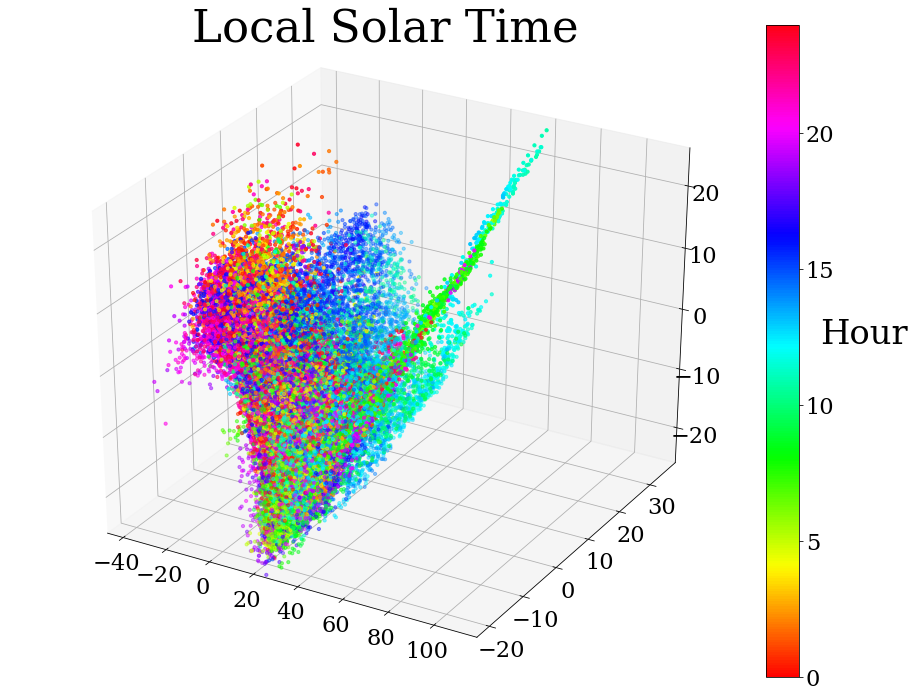

In [35]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

cp = ax.scatter(xs=z_test_tsne_track[:, 0], ys=z_test_tsne_track[:, 1], zs=z_test_tsne_track[:, 2], c=LTS_Label_final, cmap="hsv", s=10.0)
ax.set_title("Local Solar Time", fontsize = fz*2.0, y = 1.05)

ax.set_zlim(-25,25)
cbar = fig.colorbar(cp, pad=0.002)
cbar.set_label(label="Hour", rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.55)

for ii in range(360):
    ax.view_init(elev=30, azim=ii)
    if ii < 10:
        plt.savefig("Png_Storage/Diurnal_31/00"+str(ii)+".png")
    if ii >= 10 and ii < 100:
        plt.savefig("Png_Storage/Diurnal_31/0"+str(ii)+".png")
    if ii >= 100:
        plt.savefig("Png_Storage/Diurnal_31/"+str(ii)+".png")